In [1]:
import os

In [2]:
import fitsio
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import treecorr

In [3]:
import lib

In [23]:
onecolumn_kwargs = {
    "width": 1 + 1/3,
    "height": 1 + 1/3,
    "horizontal_margin": 1/6,
    "vertical_margin": 1/3,
    "horizontal_gutter": 0,
    "fig_width": 3,
    "fig_height": 2,
}

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"

In [5]:
rng = np.random.default_rng(42)

In [6]:
lib.plotting.setup()

In [7]:
twocolumn_kwargs = {
    "width": 1 + 6/8,
    "height": 2,
    "horizontal_margin": 8/12 + 1/12,
    "vertical_margin": 6/12,
    "gutter": 1/8,
    "fig_width": 7,
    "fig_height": 3,
}

In [8]:
with fitsio.FITS("/global/cfs/cdirs/desbalro/input_cosmos_v4.fits") as fits:
    input_cosmos = fits[1].read()

In [9]:
with fitsio.FITS("/global/cfs/cdirs/desbalro/input_cosmos_v4_montara_simcat_v7_seed42.fits") as fits:
    input_simcat = fits[1].read()

In [10]:
def get_mask(data):
    return (
        (data["mag_i"] > 15)
        & (data["mag_i"] <= 25)
        & (data["isgal"] == 1)
        & (data["mask_flags"] == 0)
        & (data["bdf_hlr"] > 0)
        & (data["bdf_hlr"] <= 5)
    )

In [11]:
cosmos_mask = get_mask(input_cosmos)

In [12]:
simcat_mask = get_mask(input_simcat)

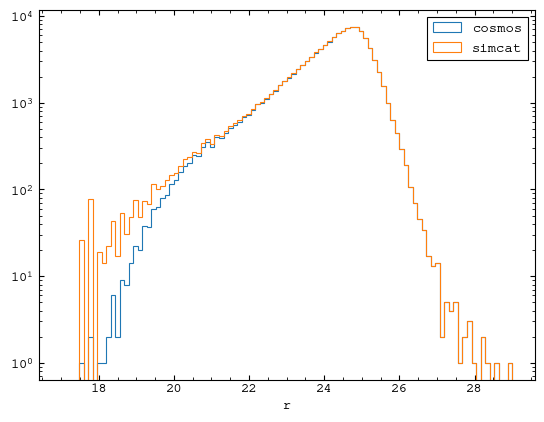

In [44]:
bins = np.linspace(17, 29, 101)
plt.hist(
    input_cosmos["mag_r_dered"][cosmos_mask],
    bins=bins,
    histtype="step",
    # density=True,
    label="cosmos",
)
plt.hist(
    input_simcat["mag_r_dered"][simcat_mask],
    bins=bins,
    histtype="step",
    # density=True,
    label="simcat",
)
plt.xlabel("r")
plt.yscale("log")
plt.legend()
plt.show()

In [14]:
with fitsio.FITS("/global/cfs/cdirs/desbalro/cosmos_simcat/cosmos_simcat_v7_DES0501-4414_seed215087633.fits") as fits:
    input_instcat = fits[1].read()

In [15]:
instcat_mask = get_mask(input_instcat) & (
    (input_instcat["x_sim"] >= 0)
    & (input_instcat["x_sim"] < 10_000)
    & (input_instcat["y_sim"] >= 0)
    & (input_instcat["y_sim"] < 10_000)
)

In [16]:
wcs = lib.util.load_wcs("DES0501-4414")

In [17]:
xv = np.array([1, 1, 10000, 10000])
yv = np.array([1, 10000, 10000, 1])

rav, decv = wcs.xyToradec(xv, yv, units="degrees")

In [19]:
ra_random = np.degrees(
    np.arccos(
        rng.uniform(
            np.min(np.cos(np.radians(rav))),
            np.max(np.cos(np.radians(rav))),
            sum(instcat_mask),
        )
    )
)
dec_random = rng.uniform(
    np.min(decv),
    np.max(decv),
    sum(instcat_mask),
)

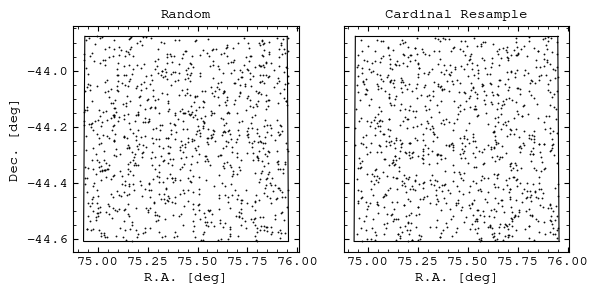

In [45]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

for i in range(rav.shape[0]):
    ip1 = (i+1) % rav.shape[0]
    axs[0].plot(
        [rav[i], rav[ip1]],
        [decv[i], decv[ip1]],
        "-k",
    )
    axs[1].plot(
        [rav[i], rav[ip1]],
        [decv[i], decv[ip1]],
        "-k",
    )
    
axs[0].scatter(
    ra_random[:1_000],
    dec_random[:1_000],
    c="k",
)
axs[0].set_xlabel("R.A. [deg]")
axs[0].set_ylabel("Dec. [deg]")
axs[0].set_title("Random")
axs[0].set_box_aspect(1)

axs[1].scatter(
    input_instcat["ra_sim"][instcat_mask][:1_000],
    input_instcat["dec_sim"][instcat_mask][:1_000],
    c="k",
)
axs[1].set_xlabel("R.A. [deg]")
# axs[1].set_ylabel("Dec. [deg]")
axs[1].set_title("Cardinal Resample")
axs[1].set_box_aspect(1)

plt.show()

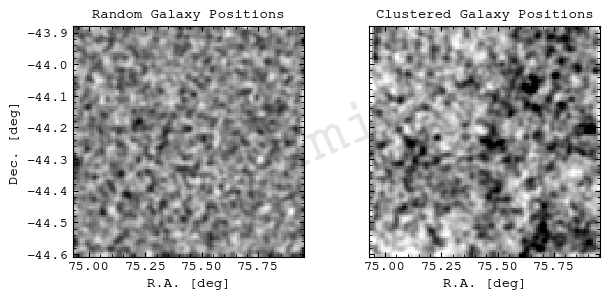

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
# fig, axs = lib.plotting.make_axes(
#     1, 2,
#     **onecolumn_kwargs,
# )

# axs[0].sharex(axs[1])
# axs[0].sharey(axs[1])

# for i in range(rav.shape[0]):
#     ip1 = (i+1) % rav.shape[0]
#     axs[0].plot(
#         [rav[i], rav[ip1]],
#         [decv[i], decv[ip1]],
#         "-k",
#     )
#     axs[1].plot(
#         [rav[i], rav[ip1]],
#         [decv[i], decv[ip1]],
#         "-k",
#     )

_xlim = axs[0].get_xlim()
_ylim = axs[0].get_ylim()

xedges = np.linspace(np.min(rav), np.max(rav), 101)
yedges = np.linspace(np.min(decv), np.max(decv), 101)

norm = mpl.colors.Normalize()

random_density, _, _ = np.histogram2d(
    ra_random,
    dec_random,
    bins=[xedges, yedges],
)
X, Y = np.meshgrid(xedges, yedges)
axs[0].pcolormesh(X, Y, gaussian_filter(random_density.T, 1), norm=norm, rasterized=True)

axs[0].set_xlabel("R.A. [deg]")
axs[0].set_ylabel("Dec. [deg]")
axs[0].set_title("Random Galaxy Positions")
axs[0].set_box_aspect(1)


instcat_density, _, _ = np.histogram2d(
    input_instcat["ra_sim"][instcat_mask],
    input_instcat["dec_sim"][instcat_mask],
    bins=[xedges, yedges],
)
X, Y = np.meshgrid(xedges, yedges)
axs[1].pcolormesh(X, Y, gaussian_filter(instcat_density.T, 1), norm=norm, rasterized=True)

axs[1].set_xlabel("R.A. [deg]")
# axs[1].set_ylabel("Dec. [deg]")
axs[1].set_title("Clustered Galaxy Positions")
axs[1].set_box_aspect(1)
# axs[1].set_yticklabels([])

# axs[0].set_xlim(_xlim)
# axs[0].set_ylim(_ylim)

# fig.suptitle("Input Density Field")

lib.plotting.watermark(fig)
fig.savefig("galaxy_density.pdf")

plt.show()

In [22]:
data_cat = treecorr.Catalog(
    ra=input_instcat["ra_sim"][instcat_mask],
    dec=input_instcat["dec_sim"][instcat_mask],
    ra_units='deg',
    dec_units='deg',
)

In [23]:
rand_cat = treecorr.Catalog(
    ra=ra_random,
    dec=dec_random,
    ra_units='deg',
    dec_units='deg',
)

In [24]:
treecorr_config = {
    "min_sep": 1e-3,
    "max_sep": 1,
    "bin_size": 0.3,
    "sep_units": "degrees",
}

In [25]:
dd = treecorr.NNCorrelation(**treecorr_config)
dd.process(data_cat)

In [26]:
rr = treecorr.NNCorrelation(**treecorr_config)
rr.process(rand_cat)

In [27]:
dr = treecorr.NNCorrelation(**treecorr_config)
dr.process(data_cat, rand_cat)

In [28]:
# r = np.exp(dd.meanlogr)
# xi, varxi = dd.calculateXi(rr=rr)
# sig = np.sqrt(varxi)

# use Landy-Szalay estimator
r = np.exp(dd.meanlogr)
xi, varxi = dd.calculateXi(rr=rr, dr=dr)
sig = np.sqrt(varxi)

In [47]:


plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='k', ls='')
plt.plot(r, -xi, color='k', ls=':')

plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='k', ls='')
plt.plot(r, xi, color='k')

# plt.errorbar(r, np.abs(xi), yerr=sig, color='k', ls='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance [deg]')
plt.ylabel('correlation')

plt.show()

NameError: name 'r' is not defined